## EDA: Index of Multiple Deprivation (IMD) in South West LSOAs

 - Loads LSOA boundaries (from .gpkg or enriched .gpkg)
 - Integrates IMD 2019, Urban/Rural, ICB, and LAD info
 - Generates summary stats and spatial plots
 - Ready for modular, downstream use

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely import wkt
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [11]:
# ## 1. Load Enriched South West LSOA GeoDataFrame

LSOA_GPKG_PATH = "../data/processed/lsoa_sw_enriched_demographics.gpkg"
LAYER_NAME = "lsoa_sw_enriched_demographics"  # Adjust if different

assert os.path.exists(LSOA_GPKG_PATH), f"Missing GPKG at {LSOA_GPKG_PATH}"
lsoa_sw = gpd.read_file(LSOA_GPKG_PATH, layer=LAYER_NAME)
print(f"Loaded {len(lsoa_sw)} South West LSOAs")
print("Columns:", lsoa_sw.columns.tolist())
display(lsoa_sw.head())

Loaded 3475 South West LSOAs
Columns: ['LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'IMD_Rank', 'LAD22CD', 'LAD22NM', 'RUC21NM', 'Urban_rural_flag', 'geometry']


,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,Shape__Are,Shape__Len,GlobalID,IMD_Rank,LAD22CD,LAD22NM,RUC21NM,Urban_rural_flag,geometry
0,E01014014,Herefordshire 018C,None,363652,243381,52.08759,-2.53190,5.488187e+07,58635.757515,8fce111a-0aab-4f99-8777-1ed10d8b04b0,13636.0,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((368107.008 23624...
1,E01014031,Herefordshire 023A,None,354699,217612,51.85525,-2.65915,1.949198e+07,28805.195706,77655486-1b21-4c99-a981-4f2fdb43ed95,13631.0,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((356772.719 21580...
2,E01014032,Herefordshire 023B,None,359935,220422,51.88092,-2.58346,2.453930e+07,36178.876984,4a1dd37e-371d-4132-baa1-1e69fb6fd97d,16442.0,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((363208.682 21811...
3,E01014036,Herefordshire 019B,None,371929,235664,52.01869,-2.41047,3.748703e+07,48290.644074,0a8efab5-acb9-44b2-acf0-e6a8d4bb460e,23031.0,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((375978.965 23592...
4,E01014053,Herefordshire 023E,None,361436,228669,51.95517,-2.56258,4.982019e+07,49048.114559,61801e80-9228-4eed-962c-96a7143de5b7,17137.0,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,"MULTILINESTRING ((365681.829 229234.482, 36569..."


In [12]:
# ## 2. Quick Diagnostics: Geometry, CRS, and IMD

print("CRS:", lsoa_sw.crs)
print("Nulls in geometry:", lsoa_sw['geometry'].isna().sum())
print("Missing IMD_Rank:", lsoa_sw['IMD_Rank'].isna().sum())
print("Unique Urban/Rural:", lsoa_sw['Urban_rural_flag'].unique())
print("ICB column present:", 'ICB23NM' in lsoa_sw.columns)


CRS: EPSG:27700
Nulls in geometry: 0
Missing IMD_Rank: 249
Unique Urban/Rural: ['Other' 'Urban']
ICB column present: False


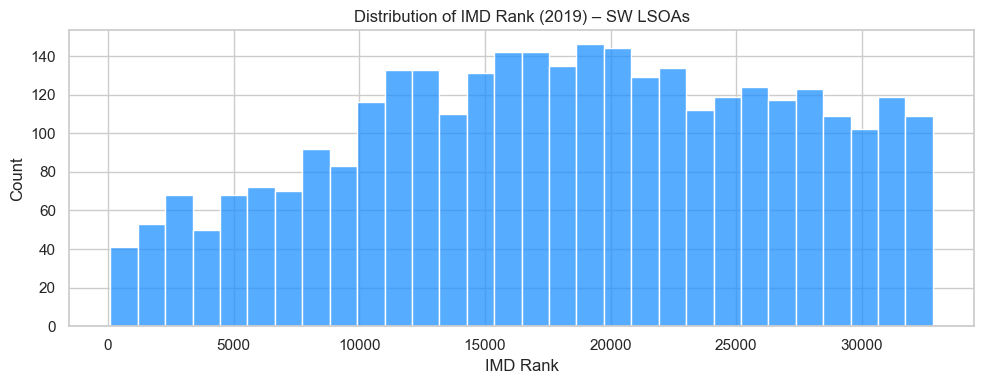

In [13]:
# ## 3. Distribution of IMD Scores

fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(lsoa_sw['IMD_Rank'].dropna(), bins=30, color='dodgerblue', ax=ax)
ax.set_title('Distribution of IMD Rank (2019) – SW LSOAs')
ax.set_xlabel('IMD Rank')
plt.tight_layout()
plt.show()


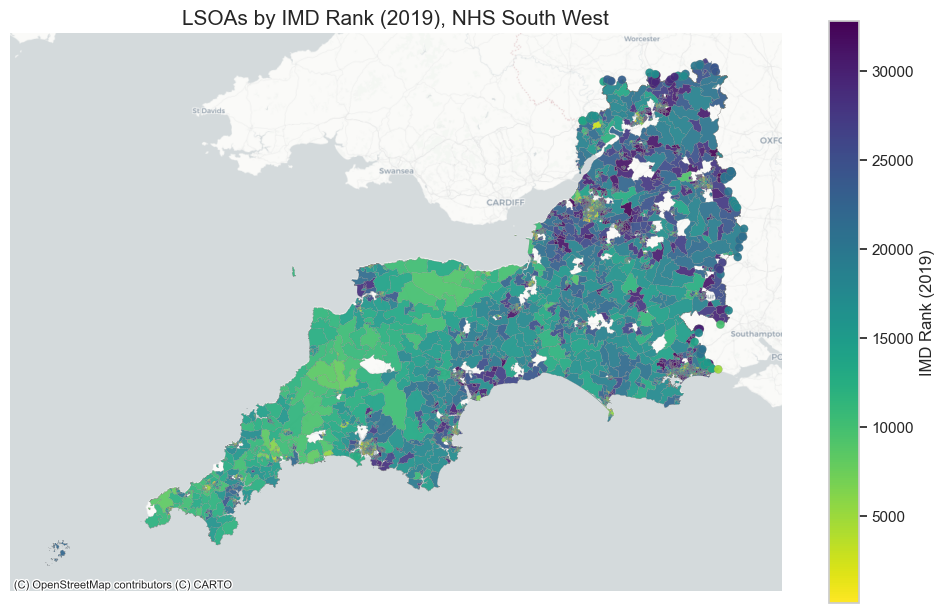

In [14]:
# ## 4. IMD Choropleth Map

fig, ax = plt.subplots(figsize=(10, 12))
lsoa_sw.to_crs(epsg=3857).plot(
    ax=ax,
    column="IMD_Rank",
    cmap="viridis_r",
    edgecolor="grey",
    linewidth=0.15,
    legend=True,
    alpha=0.93,
    legend_kwds={'label': "IMD Rank (2019)", 'shrink': 0.5}
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='EPSG:3857')
ax.set_title("LSOAs by IMD Rank (2019), NHS South West", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()


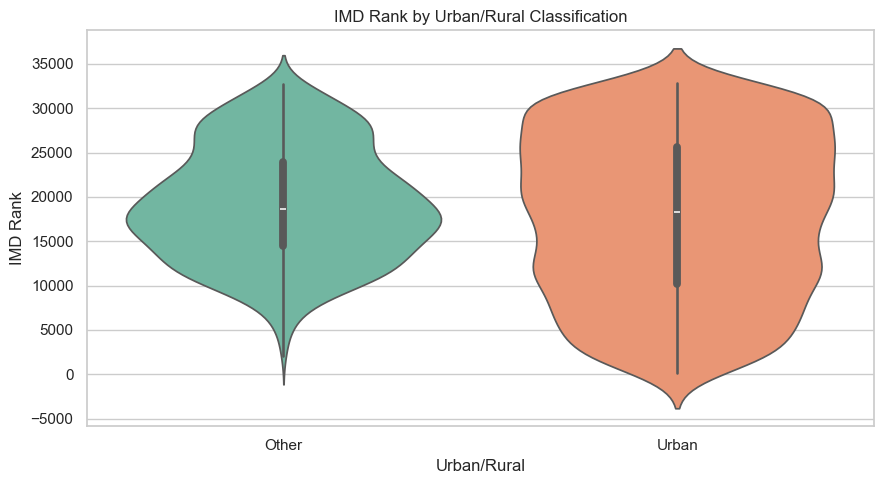

In [15]:
# ## 5. IMD by Urban/Rural Classification

fig, ax = plt.subplots(figsize=(9, 5))
sns.violinplot(
    data=lsoa_sw,
    x="Urban_rural_flag",
    y="IMD_Rank",
    inner="box",
    palette="Set2",
    ax=ax
)
ax.set_title("IMD Rank by Urban/Rural Classification")
ax.set_xlabel("Urban/Rural")
ax.set_ylabel("IMD Rank")
plt.tight_layout()
plt.show()

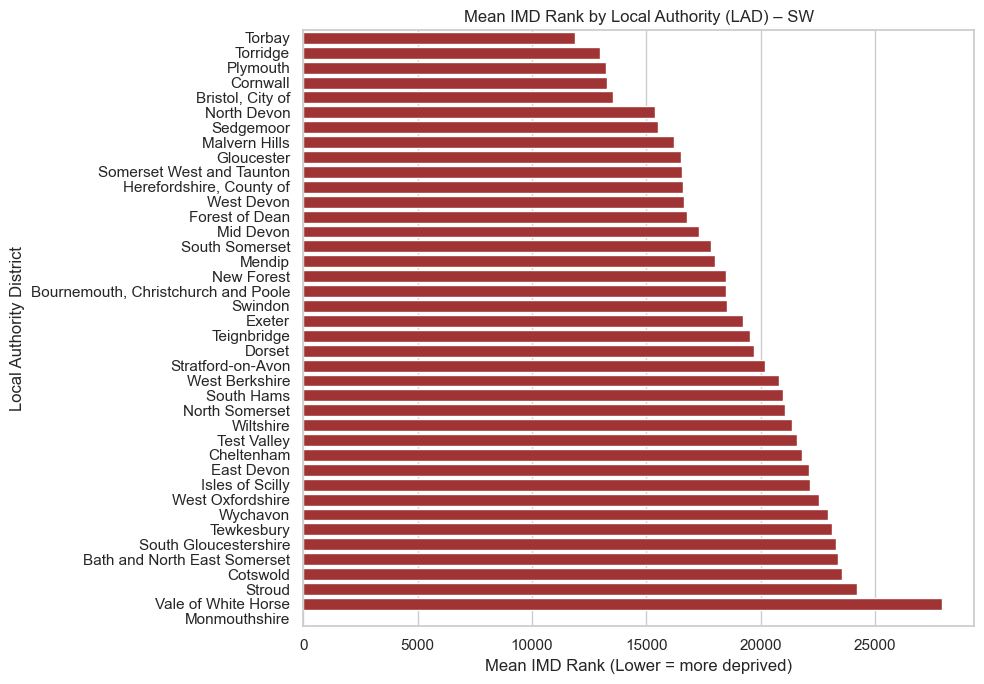

In [16]:
# ## 6. IMD by Local Authority (LAD)

lad_summary = (
    lsoa_sw.groupby("LAD22NM")["IMD_Rank"]
    .mean()
    .sort_values()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(
    data=lad_summary,
    y="LAD22NM", x="IMD_Rank", color="firebrick"
)
ax.set_title("Mean IMD Rank by Local Authority (LAD) – SW")
ax.set_xlabel("Mean IMD Rank (Lower = more deprived)")
ax.set_ylabel("Local Authority District")
plt.tight_layout()
plt.show()


In [17]:
# ## 7. IMD by ICB

if "ICB23NM" in lsoa_sw.columns:
    icb_summary = (
        lsoa_sw.groupby("ICB23NM")["IMD_Rank"]
        .mean()
        .sort_values()
        .reset_index()
    )
    fig, ax = plt.subplots(figsize=(9, 6))
    sns.barplot(data=icb_summary, x="IMD_Rank", y="ICB23NM", palette="viridis")
    ax.set_title("Mean IMD Rank by Integrated Care Board (ICB)")
    ax.set_xlabel("Mean IMD Rank (Lower = more deprived)")
    ax.set_ylabel("ICB")
    plt.tight_layout()
    plt.show()
else:
    print("ICB23NM column not found – skipping ICB IMD analysis.")


ICB23NM column not found – skipping ICB IMD analysis.


Loaded NHS England regions: 7
Columns: ['NHSER23CD', 'NHSER23NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID', 'geometry']
   NHSER23CD                 NHSER23NM
0  E40000003                    London
1  E40000005                South East
2  E40000006                South West
3  E40000007           East of England
4  E40000010                North West
5  E40000011                  Midlands
6  E40000012  North East and Yorkshire

South West NHS region geometry loaded: 1 region(s)


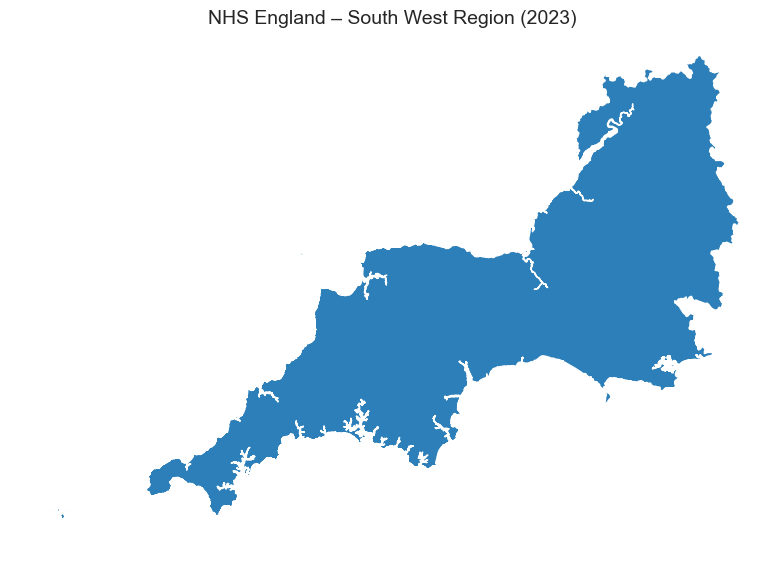

In [19]:

# Define the path to the shapefile (update if you move the data)
NHS_REGIONS_PATH = (
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/Research Project - Geospatial Health Demand/"
    "data/raw/NHS_England_Regions_December_2023/NHSER_DEC_2023_EN_BFC.shp"
)

assert os.path.exists(NHS_REGIONS_PATH), f"Missing NHS shapefile at {NHS_REGIONS_PATH}"

# Load shapefile
nhs_gdf = gpd.read_file(NHS_REGIONS_PATH)
print("Loaded NHS England regions:", len(nhs_gdf))
print("Columns:", nhs_gdf.columns.tolist())

# Quick view of unique region names and codes
print(nhs_gdf[['NHSER23CD', 'NHSER23NM']].drop_duplicates())

# Filter for South West region
sw_region = nhs_gdf[nhs_gdf["NHSER23NM"] == "South West"]

print(f"\nSouth West NHS region geometry loaded: {len(sw_region)} region(s)")

# Optional: Plot to confirm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))
sw_region.plot(ax=ax, color="#2c7fb8", edgecolor="white", linewidth=1)
ax.set_title("NHS England – South West Region (2023)", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


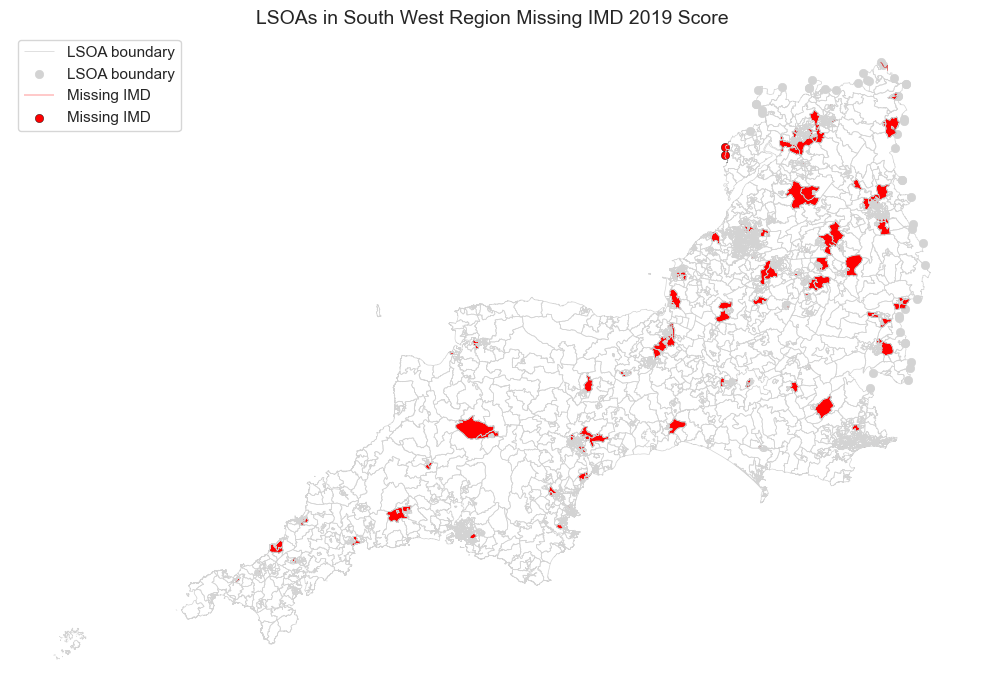

In [20]:

# ## Visualising LSOAs Missing IMD 2019 Scores

# Step 1: Filter LSOAs with missing IMD Rank
missing_imd = lsoa_sw[lsoa_sw["IMD_Rank"].isna()]

# Step 2: Plot missing LSOAs
fig, ax = plt.subplots(figsize=(10, 10))
# Plot all boundaries in light grey
lsoa_sw.boundary.plot(
    ax=ax,
    color="lightgrey",
    linewidth=0.5,
    label="LSOA boundary"
)
# Overlay missing-IMD areas in red
missing_imd.plot(
    ax=ax,
    color="red",
    edgecolor="black",
    linewidth=0.3,
    label="Missing IMD"
)

# Step 3: Format map
ax.set_title(
    "LSOAs in South West Region Missing IMD 2019 Score",
    fontsize=14
)
ax.axis("off")
ax.legend()

plt.tight_layout()
plt.show()
